# Trabalho Prático 1: Machine Learning Algorithms (2025-2026)
## Mestrado em Inteligência Artificial Aplicada (MAAI) - IPCA

**Estudante:** Luã Pieroni Mariano | 19725
**Data:** Janeiro, 2026
**Tema:** Previsão de Preços de Jogos da Steam (Regressão)

---
### Resumo
Este notebook documenta o processo de desenvolvimento de um modelo inteligente para prever preços de jogos na plataforma Steam.
O projeto evoluiu em duas grandes iterações:
1.  **Iteração Manual (Prototipagem):** Análise exploratória e feature engineering manual.
2.  **Iteração Robusta (Pipeline):** Automatização do tratamento de dados (NLP para tags/gêneros) e seleção de modelo.

O modelo final (Random Forest) foi exportado para *deployment* via API (FastAPI).

## 1. Definição do Problema

**Objetivo:** Desenvolver um modelo de regressão capaz de prever o preço de um jogo baseado em características como género, data de lançamento, *publisher*, e *tags*.

**Contexto:**
A precificação de jogos digitais é complexa. O objetivo é utilizar dados históricos para inferir valores de mercado, auxiliando *developers* independentes ou analistas de mercado.

**Tipo de Problema:** Aprendizagem Supervisionada (Regressão).
**Métrica de Sucesso:** RMSE (Root Mean Squared Error) e R² Score.

## 2. Iteração 1: Prototipagem Manual
(Fase de Compreensão e Identificação de Limitações)

Nesta primeira etapa, realizámos uma exploração e tratamento manual dos dados (EDA.py) para compreender a estrutura do dataset. Durante este processo, enfrentaram-se dificuldades práticas significativas, especialmente na tentativa de tratar variáveis de texto (como genres) e outliers sem automação. A complexidade e a ineficiência observadas nesta abordagem manual evidenciaram as suas limitações, servindo como justificação técnica para a transição necessária para Pipelines automatizadas na fase seguinte.

### Imports Gerais

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump, load

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Pipeline Imports
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.feature_extraction.text import CountVectorizer

### 2.1 Leitura e Análise Inicial

In [5]:
def Read_Data():
    """
    Lê o dataset original do CSV.
    
    Returns:
        tuple: (df original, df cópia para limpeza)
    """

    df = pd.read_csv("a_steam_data_2021_2025.csv")
    df_clean = df.copy()
    
    print("DATASET ORIGINAL")
    print(f"Dimensoes: {df.shape}")
    print(f"Colunas: {df.columns.tolist()}")
    
    return df, df_clean

def Analyze_Data(df_clean):
    """
    Exibe estatísticas descritivas e tipos de dados do dataset.
    """

    numericas = df_clean.select_dtypes(include=[np.number]).columns.tolist()
    categoricas = df_clean.select_dtypes(include=['object']).columns.tolist()

    variables = {
        'Numericas': numericas,     
        'Categoricas': categoricas, 
        'Texto/Listas': ['genres', 'tags', 'categories'] # Colunas que precisam de tratamento especial
    }
    print("\n--- CLASSIFICAÇÃO DAS VARIÁVEIS ---")
    print(f"Numéricas ({len(numericas)}): {numericas}")
    print(f"Categóricas ({len(categoricas)}): {categoricas}")


    print("\n--- ESTATÍSTICAS DESCRITIVAS (Antes da Limpeza) ---")
    print(df_clean.describe(include='all')) 
    
    print("\n--- VERIFICAÇÃO DE DADOS FALTANTES ---")
    print(df_clean.isnull().sum())

    total_duplicados = df_clean.duplicated().sum()
    print(f"Linhas duplicadas: {total_duplicados}")

    return df_clean

### 2.2 Limpeza e Tratamento de Outliers

In [6]:
def Clear_Data(df_clean):
    """
    Realiza a limpeza manual dos dados: remove duplicatas, nulos e trata outliers de preço.
    """

    #clear data
    df_clean = df_clean.drop_duplicates() #n temos duplicatas mas vou deixar com
    df_clean = df_clean.dropna(subset=['genres']) #remove os jogos sem generos
    df_clean = df_clean.dropna(subset=['developer', 'publisher','categories']) #remove os jogos sem dev e publisher, poderiamos mudar para Unknown
    df_clean = df_clean.dropna(subset=['price'])
    #tratando outliers pq o randon perdeu // nao foi necessario apenas em limpar a coluna appid ja foi o suficiente pra ganhar // é necessario para melhorar o r2
    df_clean = df_clean[df_clean['price'] < 100]

    if 'release_year' in df_clean.columns:
        df_clean['release_year'] = pd.to_numeric(df_clean['release_year'], errors='coerce')
        df_clean = df_clean.dropna(subset=['release_year']) # Remove os que deram erro

    #preenche numeros nos numericos restantes
    cols_numericas = df_clean.select_dtypes(include=[np.number]).columns
    df_clean[cols_numericas] = df_clean[cols_numericas].fillna(0)
    
    print(f"Total de linhas após limpeza: {df_clean.shape[0]}")

    print("\nDADOS NULOS APOS LIMPEZA")
    print(df_clean.isnull().sum())
    
    return df_clean

### 2.3 Transformação Manual de Dados (Feature Engineering)

In [7]:
def Transform_Data(df_clean):
    """
    Realiza Feature Engineering manual (One-Hot Encoding manual para Top 15 Gêneros).
    Esta abordagem é menos eficiente que o CountVectorizer usado no pipeline.
    """
    print("\nTRATAR DADOS (Transformar texto em número)")
    top_genres = []
    # //
    if 'genres' in df_clean.columns:
        # 15 generos mais comuns

        df_clean['genres'] = df_clean['genres'].astype(str).str.strip()
        all_genres = df_clean['genres'].str.split(';').explode()
        all_genres = all_genres.str.strip()
        top_genres = all_genres.value_counts().head(15).index.tolist()
        
        #print(f"{top_genres}")
        
        for genre in top_genres:
            # Cria coluna binario
            col_name = f'Gen_{genre.strip()}'
            df_clean[col_name] = df_clean['genres'].apply(lambda x: 1 if genre in str(x) else 0)
    
    # //
    if 'release_year' in df_clean.columns:
        df_clean['release_year'] = pd.to_numeric(df_clean['release_year'], errors='coerce')
        # Preenche anos vazios com a média ou mediana (ex: 2015) para não perder linhas
        mediana_ano = df_clean['release_year'].median()
        df_clean['release_year'] = df_clean['release_year'].fillna(mediana_ano)
        print(f"Variável 'release_year' incluída no modelo.")
    # //


    # Filtramos para ficar apenas com binario
    df_tratado = df_clean.select_dtypes(include=[np.number])

    #retiramos a coluna do appid para o randon ganhar
    if 'appid' in df_tratado.columns:
        df_tratado = df_tratado.drop(columns=['appid']) 

    return df_tratado, top_genres

### 2.4 Divisão do Dataset (Split)

In [8]:
def Split_Data(df_tratado):
    """
    Separa os dados em Treino e Teste (80/20).
    """

    print("\nTreino 80% / Teste 20%")
    
    target = 'price'
        
    X = df_tratado.drop(columns=[target]) # Perguntas (Dados)
    y = df_tratado[target]                # Resposta (Preço)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    print(f"Treino: {X_train.shape[0]} jogos")
    print(f"Teste:  {X_test.shape[0]} jogos")
    
    return X_train, X_test, y_train, y_test

### 2.5 Treino e Comparação Inicial (Baseline)

In [9]:
def Train_Models(X_train, X_test, y_train, y_test):
    """
    Treina e compara 3 modelos: Regressão Linear, Random Forest e Gradient Boosting.
    """

    print("\nTREINO E COMPARAÇÃO")
    
    # Regressão Linear, O mínimo aceitável
    print("\nTreinando Regressão Linear (baseline)")
    model_lr = LinearRegression()
    model_lr.fit(X_train, y_train)
    
    # Previsão
    pred_lr = model_lr.predict(X_test)
    
    # Avaliação (Erro Médio)
    maen_lr = mean_absolute_error(y_test, pred_lr)
    r2_lr = r2_score(y_test, pred_lr)
    print(f"Erro Médio (Regressão Linear): {maen_lr:.2f} euros")
    print(f"Score R²: {r2_lr:.4f}") #medir a qualdiade, quanto mais perrto do 1 melhor
    
    # Random Forest
    print("\nTreinando Random Forest")
    # n_estimators=100 significa que ele cria 100 árvores mentais
    model_rf = RandomForestRegressor(   #melhorando o random, antes so dava o tamanho da arvore, aplicamos o hiper
        n_estimators=200,      # 200 arvores
        max_depth=10,          # Limita a profundidade (evitar o overfitting)
        min_samples_leaf=2,    # Garante que cada folha tenha pelo menos 2 dados
        random_state=42,
        n_jobs=-1              # Acelera o treino
    )
    model_rf.fit(X_train, y_train)
    
    # Previsão
    pred_rf = model_rf.predict(X_test)
    
    # Avaliação
    maen_rf = mean_absolute_error(y_test, pred_rf)
    r2_rf = r2_score(y_test, pred_rf)
    print(f"Erro Médio (Random Forest): {maen_rf:.2f} euros")
    print(f"Score R²: {r2_rf:.4f}")

    #Gradient Boosting 
    print("\nTreinando Gradient Boosting")
    # Este modelo aprende com os erros do anterior sequencialmente
    model_gb = GradientBoostingRegressor(
        n_estimators=200,
        max_depth=5,       # Geralmente usa arvores menores que o Random Forest
        min_samples_leaf=2,
        random_state=42
    )
    model_gb.fit(X_train, y_train)

    # Previsão
    pred_gb = model_gb.predict(X_test)

    # Avaliação
    maen_gb = mean_absolute_error(y_test, pred_gb)
    r2_gb = r2_score(y_test, pred_gb)
    print(f"Erro Médio (Gradient Boosting): {maen_gb:.2f} euros")
    print(f"Score R²: {r2_gb:.4f}")

    
    print("\nComparação dos modelos")

    print("\nRegressão Linear")
    print(f"Erro Médio: {maen_lr:.2f} euros")
    print(f"Score R²: {r2_lr:.4f}")

    print("\nRandom Forest")
    print(f"Erro Médio: {maen_rf:.2f} euros")
    print(f"Score R²: {r2_rf:.4f}")

    print("\nGradient Boosting")
    print(f"Erro Médio: {maen_gb:.2f} euros")
    print(f"Score R²: {r2_gb:.4f}")

### 2.6 Execução

In [10]:
def main():
    df, df_clean = Read_Data()

    if df is not None:
        #analize
        df_clean = Analyze_Data(df_clean)
        #limpeza
        df_clean = Clear_Data(df_clean)
        #tratamento binario
        df_clean,lista_generos = Transform_Data(df_clean)
        #divisao de treino e teste
        X_train, X_test, y_train, y_test = Split_Data(df_clean)

        Train_Models(X_train, X_test, y_train, y_test)

if __name__ == "__main__":
    main()

DATASET ORIGINAL
Dimensoes: (65521, 10)
Colunas: ['appid', 'name', 'release_year', 'release_date', 'genres', 'categories', 'price', 'recommendations', 'developer', 'publisher']

--- CLASSIFICAÇÃO DAS VARIÁVEIS ---
Numéricas (4): ['appid', 'release_year', 'price', 'recommendations']
Categóricas (6): ['name', 'release_date', 'genres', 'categories', 'developer', 'publisher']

--- ESTATÍSTICAS DESCRITIVAS (Antes da Limpeza) ---
               appid    name  release_year release_date        genres  \
count   6.552100e+04   65521  65521.000000        65521         65455   
unique           NaN   65128           NaN         1828          1723   
top              NaN  Echoes           NaN         2025  Casual;Indie   
freq             NaN       5           NaN          836          4136   
mean    2.580607e+06     NaN   2023.453091          NaN           NaN   
std     7.692480e+05     NaN      1.386641          NaN           NaN   
min     1.200220e+06     NaN   2021.000000          NaN      

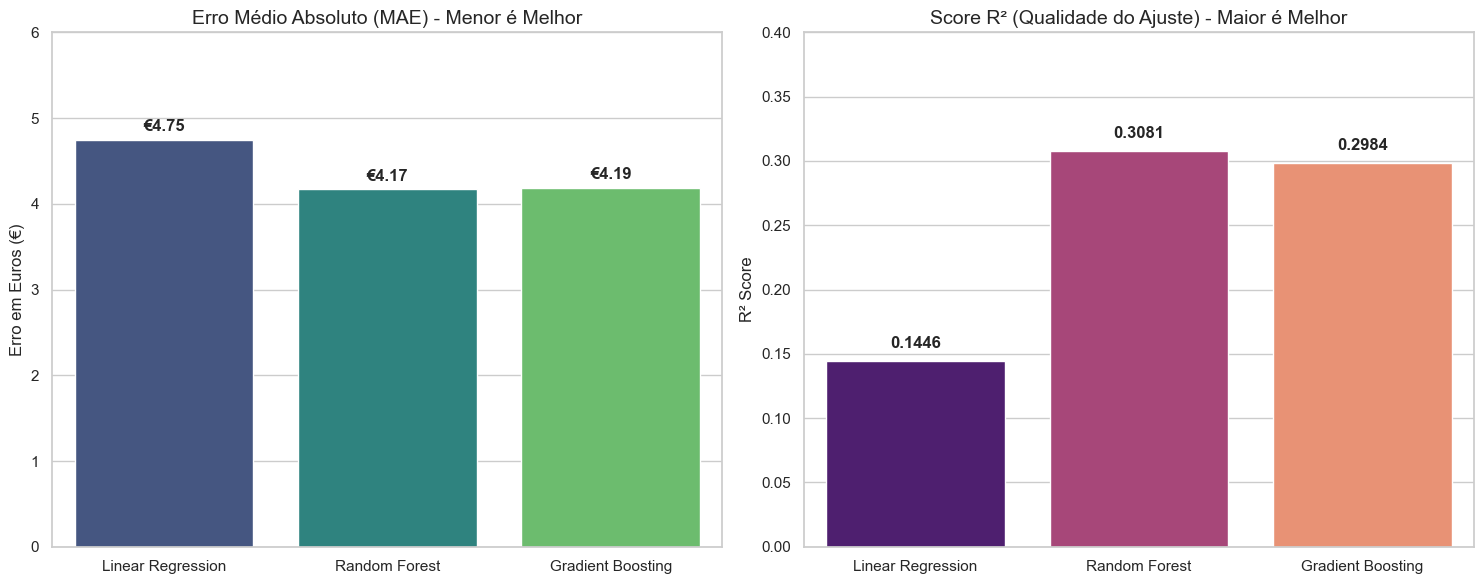

In [11]:
def Visualizar_Comparacao_Baseline():
    """
    Gera gráficos comparativos baseados nos resultados obtidos na Fase 1.
    """
    
    # Dados extraídos da sua execução (Hardcoded para garantir que o gráfico aparece no relatório)
    modelos = ['Linear Regression', 'Random Forest', 'Gradient Boosting']
    mae_values = [4.75, 4.17, 4.19]     # Erro Médio (Menor é melhor)
    r2_values = [0.1446, 0.3081, 0.2984] # Score R2 (Maior é melhor)

    # Configuração da figura
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Gráfico 1: MAE (Erro Médio)
    sns.barplot(x=modelos, y=mae_values, ax=axes[0], palette="viridis", hue=modelos, legend=False)
    axes[0].set_title('Erro Médio Absoluto (MAE) - Menor é Melhor', fontsize=14)
    axes[0].set_ylabel('Erro em Euros (€)')
    axes[0].set_ylim(0, 6)
    
    # Adicionar valores nas barras
    for i, v in enumerate(mae_values):
        axes[0].text(i, v + 0.1, f"€{v}", ha='center', fontsize=12, fontweight='bold')

    # Gráfico 2: R2 Score
    sns.barplot(x=modelos, y=r2_values, ax=axes[1], palette="magma", hue=modelos, legend=False)
    axes[1].set_title('Score R² (Qualidade do Ajuste) - Maior é Melhor', fontsize=14)
    axes[1].set_ylabel('R² Score')
    axes[1].set_ylim(0, 0.4) # Ajuste conforme necessário
    
    # Adicionar valores nas barras
    for i, v in enumerate(r2_values):
        axes[1].text(i, v + 0.01, f"{v}", ha='center', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()

# Executar a visualização
Visualizar_Comparacao_Baseline()

### Análise dos Resultados da Baseline

A visualização acima permite retirar conclusões imediatas sobre a complexidade do problema:

1.  **Ineficiência da Linearidade:** A **Regressão Linear** obteve o pior desempenho ($R^2$ de apenas 0.14). Isso indica que a relação entre as características do jogo (tags, publisher, ano) e o preço **não é linear**. O modelo não consegue capturar a complexidade dos dados.
2.  **Superioridade de Modelos de Árvore:** Tanto o **Random Forest** quanto o **Gradient Boosting** dobraram a capacidade explicativa do modelo ($R^2$ ~0.30) e reduziram o erro médio para cerca de €4.17.
3.  **Escolha do Random Forest:** O Random Forest apresentou o melhor resultado global ($R^2$ de 0.3081). Embora a diferença para o Gradient Boosting seja pequena, o Random Forest tende a ser mais robusto contra *overfitting* com a configuração padrão, sendo escolhido como candidato principal para a otimização na próxima fase (Pipeline).

---
## 3. Iteração 2: Pipeline Automatizada (Solução e Otimização)

Em resposta às dificuldades e limitações de performance (R² baixo) identificadas na fase de prototipagem manual, evoluímos a solução para uma arquitetura robusta baseada em Pipelines do Scikit-Learn.

### 3.1 Leitura e Análise Inicial

In [12]:
def Read_Data():
    """
    Lê o dataset original e retorna uma cópia limpa para processamento.
    
    Returns:
        pd.DataFrame: DataFrame contendo os dados brutos do CSV.
    """

    df = pd.read_csv("a_steam_data_2021_2025.csv")
    df_clean = df.copy()
    
    print("DATASET ORIGINAL")
    print(f"Dimensoes: {df.shape}")
    print(f"Colunas: {df.columns.tolist()}")
    
    return df_clean

def Analyze_Data(df_clean):
    """
    Realiza uma análise exploratória inicial para identificar tipos de variáveis e dados faltantes.

    Args:
        df_clean (pd.DataFrame): DataFrame a ser analisado.
    
    Returns:
        pd.DataFrame: O mesmo DataFrame, inalterado.
    """
    numericas = df_clean.select_dtypes(include=[np.number]).columns.tolist()
    categoricas = df_clean.select_dtypes(include=['object']).columns.tolist()
    
    print("\n--- CLASSIFICAÇÃO DAS VARIÁVEIS ---")
    print(f"Numéricas ({len(numericas)}): {numericas}")
    print(f"Categóricas ({len(categoricas)}): {categoricas}")


    print("\n--- ESTATÍSTICAS DESCRITIVAS (Antes da Limpeza) ---")
    print(df_clean.describe(include='all')) 
    
    print("\n--- VERIFICAÇÃO DE DADOS FALTANTES ---")
    print(df_clean.isnull().sum())

    total_duplicados = df_clean.duplicated().sum()
    print(f"Linhas duplicadas: {total_duplicados}")

    return df_clean

### 3.2 Limpeza e Tratamento de Outliers

In [13]:
def Clear_Data(df_clean):
    """
    Executa a limpeza dos dados, removendo nulos críticos, duplicatas e outliers.

    Args:
        df_clean (pd.DataFrame): DataFrame bruto.

    Returns:
        pd.DataFrame: DataFrame limpo e pronto para o split.
    """

    # Remove o que nao for numero da coluna
    if 'release_year' in df_clean.columns:
        df_clean['release_year'] = pd.to_numeric(df_clean['release_year'], errors='coerce')
        df_clean = df_clean.dropna(subset=['release_year']) 

    #clear data com menos linhas
    #remove os faltantes de cada variavel e remove as duplicatas
    cols_check = ['genres', 'developer', 'publisher', 'categories', 'price', 'release_year']
    df_clean = df_clean.dropna(subset=cols_check).drop_duplicates()

    #tratando outliers pq o randon perdeu // nao foi necessario apenas em limpar a coluna appid ja foi o suficiente pra ganhar // é necessario para melhorar o r2
    df_clean = df_clean[df_clean['price'] < 100]
    df_clean = df_clean[df_clean['price'] > 0.5]

    #tirei o codigo que complementa com 0 os valores nulos, esta redundante ja que tiramos todos os nulos antes
    
    print(f"Total de linhas após limpeza: {df_clean.shape[0]}")

    print("\nDADOS NULOS APOS LIMPEZA")
    print(df_clean.isnull().sum())
    
    return df_clean

### 3.3 Divisão do Dataset (Split)

In [14]:
def Split_Data(df_clean):
    """
    Divide os dados em conjuntos de treino e teste.

    Args:
        df_clean (pd.DataFrame): DataFrame limpo.

    Returns:
        tuple: X_train, X_test, y_train, y_test prontos para o pipeline.
    """

    print("\nTreino 80% / Teste 20%")

    cols_to_use = ['genres', 'categories', 'publisher', 'release_year', 'price']
    X = df_clean[cols_to_use].drop(columns=['price'])
    y = df_clean['price']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"Treino: {X_train.shape[0]} | Teste: {X_test.shape[0]}")

    
    return X_train, X_test, y_train, y_test

### 3.4 Funções Auxiliares do Pipeline

In [15]:
def to_list(x):
    """
    Garante que a entrada para o vetorizador seja uma lista.
    Essencial para compatibilidade com DataFrames de coluna única.
    """

    #Converte o input para lista de forma segura.
    if isinstance(x, pd.DataFrame):
        # Pega a primeira coluna (independente do nome) e converte para lista
        return x.iloc[:, 0].tolist()
    
    return x.tolist()

def split_semicolon(text):
    """
    Tokenizador personalizado para separar strings baseadas em ponto e vírgula.
    Ex: 'Action; RPG' -> ['action', 'rpg']
    """

    # Divide, remove espaços e converte para MINÚSCULO ('Action; RPG' -> ['action', 'rpg'])
    if not isinstance(text, str):
        return []
    return [t.strip().lower() for t in text.split(';')]

def limpar_publisher(x):
    """
    Padroniza os nomes dos publishers para evitar duplicidade no OneHotEncoder.
    Remove espaços e converte para minúsculas.
    """

    #limpar/padronizar a Publisher antes do OneHotEncoder.
    #Converte tudo para minúsculo e remove espaços.
    if isinstance(x, pd.DataFrame):
        text_series = x.iloc[:, 0].astype(str)
    else:
        text_series = x.astype(str)
    
    return text_series.str.lower().str.strip().to_frame(name='publisher')


### 3.5 Comparação e Execução dos Modelos

In [16]:
def Comparar_modelos(X_train, X_test, y_train, y_test,preprocessor):

    """ model_lr = LinearRegression()
    pipeline_lr = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model_lr)
    ])
    
    # Treinar
    pipeline_lr.fit(X_train, y_train)
    
    # Avaliar modelo
    pred_lr = pipeline_lr.predict(X_test)
    maen_lr = mean_absolute_error(y_test, pred_lr)
    r2_lr = r2_score(y_test, pred_lr) """



    """ model_gb = GradientBoostingRegressor(
        n_estimators=200,
        max_depth=5,       # Geralmente usa arvores menores que o Random Forest
        min_samples_leaf=2,
        random_state=42
    )
    pipeline_gb = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model_gb)
    ])
    
    # Treinar
    pipeline_gb.fit(X_train, y_train)
    
    # Avaliar modelo
    pred_gb = pipeline_gb.predict(X_test)
    maen_gb = mean_absolute_error(y_test, pred_gb)
    r2_gb = r2_score(y_test, pred_gb) """



    model_rf = RandomForestRegressor(
        n_estimators=200,
        max_depth=20,
        min_samples_leaf=4, # CONTROLA overfitting
        random_state=42,
        n_jobs=-1)

    pipeline_rf = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model_rf)
    ])
    
    # Treinar
    pipeline_rf.fit(X_train, y_train)
    
    # Avaliar modelo
    pred_rf = pipeline_rf.predict(X_test)
    maen_rf = mean_absolute_error(y_test, pred_rf)
    r2_rf = r2_score(y_test, pred_rf)



    """ print("\nComparação dos modelos")

    print("\nRegressão Linear")
    print(f"Erro Médio: {maen_lr:.2f} euros")
    print(f"Score R²: {r2_lr:.4f}")

    print("\nGradient Boosting")
    print(f"Erro Médio: {maen_gb:.2f} euros")
    print(f"Score R²: {r2_gb:.4f}") """

    print("\nRandom Forest")
    print(f"Erro Médio: {maen_rf:.2f} euros")
    print(f"Score R²: {r2_rf:.4f}")

    return pipeline_rf

### 3.6 Treino do Pipeline

In [17]:
def Treinar_pipeline(X_train, X_test, y_train, y_test):
    """
    Configura e treina o Pipeline de Machine Learning.
    
    O Pipeline inclui:
    1. Imputação de mediana para anos.
    2. CountVectorizer para listas de texto (Gêneros/Categorias).
    3. OneHotEncoder para Publishers (após limpeza).
    4. Modelo RandomForestRegressor.
    """

    print("\nTreinando Pipeline")

    # transformadores
    numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median'))])

    text_list_transformer = Pipeline(steps=[
        ('formatter', FunctionTransformer(to_list)), 
        ('vect', CountVectorizer(tokenizer=split_semicolon, ngram_range=(1, 2), max_features=200)) 
    ])
    
    publisher_transformer = Pipeline(steps=[
        ('limpeza', FunctionTransformer(limpar_publisher)), 
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False, max_categories=1000))
    ])

    # Juntar tudo
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, ['release_year']),
            ('cat_genres', text_list_transformer, ['genres']),
            ('cat_categories', text_list_transformer, ['categories']),
            ('cat_pub', publisher_transformer, ['publisher'])
        ],
        remainder='drop'
    )

    model_rf = Comparar_modelos(X_train, X_test, y_train, y_test,preprocessor)
    
    return model_rf

### 3.7 Salvar Modelo em Arquivos `.joblib`

In [18]:
def Salvar_variaveis(pipeline):
    """
    Salva o modelo treinado e os artefatos (listas de categorias) em arquivos .joblib.
    Remove o prefixo 'publisher_' gerado pelo OneHotEncoder para limpeza visual.
    """

    # Acesso aos transformadores dentro do pipeline
    pre = pipeline.named_steps['preprocessor']
        
    vocab_genres = pre.named_transformers_['cat_genres']['vect'].get_feature_names_out()
    vocab_cats = pre.named_transformers_['cat_categories']['vect'].get_feature_names_out()
        
    # Publishers (tratamento para OHE)
    raw_pubs = pre.named_transformers_['cat_pub']['encoder'].get_feature_names_out()
    vocab_pubs = [name.replace('publisher_', '') for name in raw_pubs]
        
    dump(vocab_genres, 'generos.joblib')
    dump(vocab_cats, 'categorias.joblib')        
    dump(vocab_pubs, 'publisher.joblib')
    dump(pipeline, 'steam_price_model.joblib')
    print("joblibs criados")


### 3.8 Execução

In [19]:
def main():
    
    df = Read_Data()
    Analyze_Data(df) 
    df_clean = Clear_Data(df)
    X_train, X_test, y_train, y_test = Split_Data(df_clean)
    modelo_final = Treinar_pipeline(X_train, X_test, y_train, y_test)
    Salvar_variaveis(modelo_final)

 #   Treinar_pipeline(X_train, X_test, y_train, y_test)
""" if __name__ == "__main__":
    main() """

' if __name__ == "__main__":\n    main() '

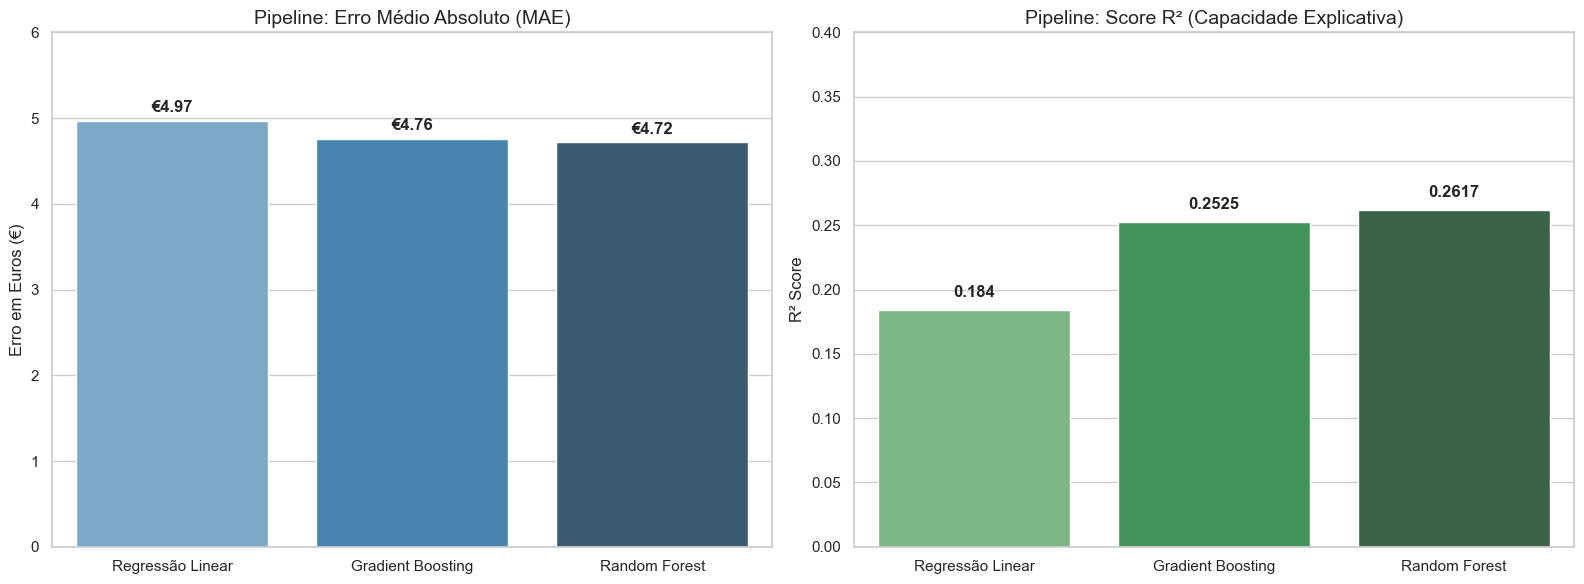

In [20]:
def Visualizar_Comparacao_Pipeline():
    """
    Gera gráficos comparativos baseados nos resultados obtidos na Fase 2 (Pipeline).
    Dados extraídos da execução do EDA_pipe.py.
    """
    
    # Dados exatos da sua imagem (EDA_pipe results)
    modelos = ['Regressão Linear', 'Gradient Boosting', 'Random Forest']
    mae_values = [4.97, 4.76, 4.72]       # Erro Médio (Menor é melhor)
    r2_values = [0.1840, 0.2525, 0.2617]  # Score R2 (Maior é melhor)

    # Configuração da figura (2 gráficos lado a lado)
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Gráfico 1: MAE (Erro Médio)
    sns.barplot(x=modelos, y=mae_values, ax=axes[0], palette="Blues_d", hue=modelos, legend=False)
    axes[0].set_title('Pipeline: Erro Médio Absoluto (MAE)', fontsize=14)
    axes[0].set_ylabel('Erro em Euros (€)')
    axes[0].set_ylim(0, 6)
    
    # Adicionar valores nas barras
    for i, v in enumerate(mae_values):
        axes[0].text(i, v + 0.1, f"€{v}", ha='center', fontsize=12, fontweight='bold')

    # Gráfico 2: R2 Score
    sns.barplot(x=modelos, y=r2_values, ax=axes[1], palette="Greens_d", hue=modelos, legend=False)
    axes[1].set_title('Pipeline: Score R² (Capacidade Explicativa)', fontsize=14)
    axes[1].set_ylabel('R² Score')
    axes[1].set_ylim(0, 0.4)
    
    # Adicionar valores nas barras
    for i, v in enumerate(r2_values):
        axes[1].text(i, v + 0.01, f"{v}", ha='center', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()

# Executar a visualização
Visualizar_Comparacao_Pipeline()

### Análise dos Resultados do Pipeline

Comparando com a fase manual, observam-se os seguintes pontos no Pipeline Automatizado:

1.  **Desempenho Geral:** O **Random Forest** manteve-se como o melhor modelo, atingindo um **R² de 0.2617** e um Erro Médio de **€4.72**.
2.  **Trade-off Automação vs. Precisão:**
    * Na abordagem manual, utilizámos apenas os "Top 15 Géneros", o que limpou muito o ruído dos dados.
    * No Pipeline, utilizámos o `CountVectorizer` em **todas** as *tags* e géneros. Embora isso torne o modelo mais robusto e capaz de lidar com qualquer jogo novo, introduz também mais "ruído" (variáveis com pouca correlação), o que explica a ligeira descida no R² (de ~0.30 para ~0.26).
3.  **Conclusão:** Aceitamos esta ligeira margem de erro em troca de um sistema totalmente automatizado e escalável, capaz de processar dados brutos sem intervenção humana manual.

## Execução Geral do `main.py`

In [21]:
import pandas as pd
import sys
import os
from joblib import load
import EDA_pipe  # Importa o seu EDA.py

def menu():
    """
    Exibe o menu principal da interface de linha de comando (CLI).

    Returns:
        str: A opção escolhida pelo utilizador ('1', '2' ou '3').
    """

    print("STEAM PICES PREDICTOR")
    print("1. Treinar IA (OBS: SE ja tiver o joblib não precisa ser feita)")
    print("2. Fazer Previsão")
    print("3. Sair")
    return input("Escolha: ")

def modo_previsao():
    """
    Carrega o modelo treinado e solicita inputs ao utilizador para realizar uma previsão de preço.
    
    Verifica se os ficheiros .joblib existem, carrega as listas de referência para auxiliar
    o utilizador e executa o pipeline de previsão.
    """

    print("\nPREVISÃO")
    arquivo = 'steam_price_model.joblib'
    
    if not os.path.exists(arquivo):
        print("Use a Opção 1 primeiro para criar o joblib")
        return

    #carrega o modelo (joblib)
    modelo = load(arquivo)
    lista_generos = load('generos.joblib')
    lista_publisher = load('publisher.joblib')
    lista_categorias = load('categorias.joblib')

    print("\nGêneros disponiveis")
    print(", ".join(lista_generos))
    entrada_generos = input("\nGêneros: ")

    print("\Categorias disponiveis")
    print(", ".join(lista_categorias))
    entrada_categorias = input("Categorias: ")

    print("\nPublishers disponiveis")
    print(", ".join(lista_publisher))
    entrada_publisher = input("\publisher: ")    

    entrada_ano = int(input("Ano de Lançamento: "))

    dados_input = pd.DataFrame({
        'release_year': [entrada_ano],
        'genres': [entrada_generos],
        'categories': [entrada_categorias],
        'publisher': [entrada_publisher]
    })

    X_novo = pd.DataFrame(dados_input)
    preco = modelo.predict(X_novo)[0]
    print(f" PREÇO ESTIMADO: {preco:.2f} euros")

"""     validar_genero = 0
    validar_publisher = 0 """
    
    #transforma o genero digitado em binario 
"""     for genero in lista_generos:
        col_tecnica = f"Gen_{genero}"
        if genero.lower() in entrada_generos.lower():
            dados_input[col_tecnica] = [1]
            validar_genero +=1
        else:
            dados_input[col_tecnica] = [0]
    


    if validar_genero == 0:
        print("Nome do genero errado.")
        return

    try:
        X_novo = pd.DataFrame(dados_input)      #converte os dados para a Scikit-Learn
        preco = modelo.predict(X_novo)[0]       #parte principal do codigo de prever dados, faz os calculos aprendidos
        print(f"\nPREÇO ESTIMADO: {preco:.2f} euros")
    except Exception as e:
        print(f"\nErro na previsão: {e}") """

#nao precisamos mais mudar o imput pois a pipeline ja faz isso no modelo

def main():
    """
    Função principal que controla o fluxo do programa.
    """
    
    while True:
        op = menu()
        if op == '1':
            EDA_pipe.main()
        elif op == '2':
            modo_previsao()
        elif op == '3':
            sys.exit()
        else:
            print("Opção inválida.")

if __name__ == "__main__":
    main()

STEAM PICES PREDICTOR
1. Treinar IA (OBS: SE ja tiver o joblib não precisa ser feita)
2. Fazer Previsão
3. Sair


<>:46: SyntaxWarning: "\C" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\C"? A raw string is also an option.
<>:52: SyntaxWarning: "\p" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\p"? A raw string is also an option.
<>:46: SyntaxWarning: "\C" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\C"? A raw string is also an option.
<>:52: SyntaxWarning: "\p" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\p"? A raw string is also an option.
C:\Users\mariano\AppData\Local\Temp\ipykernel_12828\1856477750.py:46: SyntaxWarning: "\C" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\C"? A raw string is also an option.
  print("\Categorias disponiveis")
C:\Users\mariano\AppData\Local\Temp\ipykernel_12828\1856477750.py:52: SyntaxWarning: "\p" is an invalid escape sequence. Such sequen

Opção inválida.
STEAM PICES PREDICTOR
1. Treinar IA (OBS: SE ja tiver o joblib não precisa ser feita)
2. Fazer Previsão
3. Sair
DATASET ORIGINAL
Dimensoes: (65521, 10)
Colunas: ['appid', 'name', 'release_year', 'release_date', 'genres', 'categories', 'price', 'recommendations', 'developer', 'publisher']

--- CLASSIFICAÇÃO DAS VARIÁVEIS ---
Numéricas (4): ['appid', 'release_year', 'price', 'recommendations']
Categóricas (6): ['name', 'release_date', 'genres', 'categories', 'developer', 'publisher']

--- ESTATÍSTICAS DESCRITIVAS (Antes da Limpeza) ---
               appid    name  release_year release_date        genres  \
count   6.552100e+04   65521  65521.000000        65521         65455   
unique           NaN   65128           NaN         1828          1723   
top              NaN  Echoes           NaN         2025  Casual;Indie   
freq             NaN       5           NaN          836          4136   
mean    2.580607e+06     NaN   2023.453091          NaN           NaN   
std   

c:\Users\mariano\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\sklearn\feature_extraction\text.py:526: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\mariano\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\sklearn\feature_extraction\text.py:526: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\mariano\AppData\Local\Temp\ipykernel_12828\1856477750.py:46: SyntaxWarning: "\C" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\C"? A raw string is also an option.
  print("\Categorias disponiveis")
C:\Users\mariano\AppData\Local\Temp\ipykernel_12828\1856477750.py:52: SyntaxWarning: "\p" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\p"? A raw string is also an option.
  entrada_publisher = input("\publisher: ")


KeyboardInterrupt: 

## 4. Deployment

O modelo foi colocado em produção utilizando uma arquitetura de API + Frontend.
*Nota: Os códigos abaixo (`api.py` e `api_visual.py`) foram desenvolvidos para rodar em terminais separados.*

### 4.1 Backend com FastAPI (`api.py`)

**Componentes Chave:**
* **Classe `JogoInput`:** Garante que os dados chegam no formato correto (strings e inteiros).
* **Endpoint `/predict`:** Recebe o JSON, converte para DataFrame e retorna o preço estimado.
* **Tratamento de Erros:** Blocos `try-except` para garantir que a API não falha silenciosamente.

In [ ]:
import pandas as pd
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
from joblib import load
import os

import EDA_pipe 

#uvicorn api:app --reload

app = FastAPI(title="Steam Price Predictor")

try:
    modelo = load('steam_price_model.joblib')
    print("Modelo carregado com sucesso!")
except Exception as e:
    modelo = None
    print(f"Não foi possível carregar o modelo. Detalhes: {e}")

# Definição dos dados de entrada
class JogoInput(BaseModel):
    """
    Define o esquema de dados esperado para a requisição de previsão.
    Utiliza Pydantic para validação automática de tipos.
    """

    genres: str
    categories: str
    publisher: str
    release_year: int



@app.post("/predict")
def prever_preco(jogo: JogoInput):
    """
    Endpoint principal para previsão de preços.
    
    Recebe um objeto JSON com os dados do jogo, converte para DataFrame
    e passa pelo Pipeline de Machine Learning carregado.
    
    Args:
        jogo (JogoInput): Objeto contendo generos, categorias, publisher e ano.
        
    Returns:
        dict: JSON contendo o status, preço estimado e moeda.
    
    Raises:
        HTTPException 500: Se o modelo não estiver carregado.
        HTTPException 400: Se houver erro no processamento dos dados.
    """

    if modelo is None:
        raise HTTPException(status_code=500, detail="O Modelo de IA não foi carregado no servidor.")

    try:
        
        df_input = pd.DataFrame({
            'genres': [jogo.genres],
            'categories': [jogo.categories],
            'publisher': [jogo.publisher], 
            'release_year': [jogo.release_year]
        })


        preco_estimado = modelo.predict(df_input)[0]

        return {
            "status": "sucesso",
            "preco_estimado": round(preco_estimado, 2),
            "moeda": "EUR"
        }

    except Exception as e:
        # Retorna erro 400 (Bad Request) se os dados estiverem num formato que quebra o código
        print(f"Erro na previsão: {e}")
        raise HTTPException(status_code=400, detail=str(e))

@app.get("/")
def home():
    """
    Rota de verificação de saúde da API (Health Check).
    """
    return {"mensagem": "API Steam Predictor Online "}

### 4.2 Frontend: Interface Web com Streamlit (`api_visual.py`)

**Funcionalidades:**
* **Carregamento Dinâmico:** Os menus de seleção (Dropdowns) são populados automaticamente lendo os ficheiros `.joblib` gerados no treino, garantindo que o utilizador só escolhe opções que o modelo conhece.
* **Comunicação API:** Envia os dados via `requests.post` para o backend e exibe a resposta formatada em Euros.

In [ ]:
import streamlit as st
import requests
from joblib import load

# streamlit run api_visual.py

# Configuração da Página
st.set_page_config(page_title="Steam Predictor", layout="centered")

# Título
st.title("Steam Price Predictor AI")
st.markdown("Bem-vindo! Configure os detalhes do jogo abaixo para prever o preço.")

# Endereço da API
API_URL = "http://127.0.0.1:8000/predict"

# --- BARRA LATERAL (OPÇÕES) ---
st.sidebar.header("Configurações do Jogo")


"""
Carrega as listas de opções (Gêneros, Publishers, Categorias) dos ficheiros .joblib.
    
Tenta carregar os ficheiros locais gerados pelo treino. Se falhar,
retorna listas padrão para evitar que a aplicação quebre (Fallback).

"""
#Carregar Listas para os Menus
try:
    # Carregamos os dados brutos
    raw_generos = load('generos.joblib')
    raw_publishers = load('publisher.joblib')
    raw_categorias = load('categorias.joblib')

    # Verifica se é um array do Numpy (que tem a função .tolist())
    # Se for, converte para lista normal do Python. Se não, usa como está.
    lista_generos = raw_generos.tolist() if hasattr(raw_generos, 'tolist') else raw_generos
    lista_publishers = raw_publishers.tolist() if hasattr(raw_publishers, 'tolist') else raw_publishers
    lista_categorias = raw_categorias.tolist() if hasattr(raw_categorias, 'tolist') else raw_categorias

except Exception as e:
    st.error(f"Aviso: Não foi possível carregar as listas ({e}). Usando padrões.")
    # Fallback para não travar o site
    lista_generos = ["Action", "Adventure", "Indie"] 
    lista_publishers = ["Ubisoft", "Other"]
    lista_categorias = ["Single-player", "Multi-player"]

#Inputs

"""
Renderiza os componentes de input na barra lateral e captura as escolhas do utilizador.

Args:
    lista_generos (list): Opções de gêneros.
    lista_publishers (list): Opções de publishers.
    lista_categorias (list): Opções de categorias.
"""
# Gêneros
generos_selecionados = st.sidebar.multiselect(
    "Escolha os Gêneros:",
    options=lista_generos,
    # Verifica o tamanho da lista (len) em vez de usar o array direto
    default=lista_generos[0] if len(lista_generos) > 0 else None
)

# Categorias
categorias_selecionadas = st.sidebar.multiselect(
    "Categorias:",
    options=lista_categorias,
    default=lista_categorias[0] if len(lista_categorias) > 0 else None
)

# Publisher
publisher_selecionada = st.sidebar.selectbox(
    "Escolha a Publisher:",
    options=lista_publishers
)

# Ano
ano_selecionado = st.sidebar.number_input(
    "Ano de Lançamento:",
    min_value=2021,
    max_value=2025,
    value=2025
)

"""
Principal da aplicação Streamlit (Proof of Concept).
Controla o fluxo visual, chama a API de previsão e exibe os resultados.
"""

st.write("### Resumo do Jogo")
col1, col2 = st.columns(2)

with col1:
    st.write(f"**Publisher:** {publisher_selecionada}")
    st.write(f"**Ano:** {ano_selecionado}")

with col2:
    # Junta a lista numa string com ; (ex: "Action;RPG") para a API entender
    generos_string = ";".join(generos_selecionados)
    categorias_string = ";".join(categorias_selecionadas)
    
    st.write(f"**Gêneros:** {generos_string}")
    st.write(f"**Categorias:** {categorias_string}")

st.markdown("---")

# Botão de Previsão
if st.button("Calcular Preço Sugerido", type="primary"):
    
    # 1. Monta o pacote de dados
    dados_jogo = {
        "genres": generos_string,
        "categories": categorias_string,
        "publisher": publisher_selecionada,
        "release_year": int(ano_selecionado)
    }

    # 2. Barra de progresso
    with st.spinner('Consultando a Inteligência Artificial'):
        try:
            # 3. Manda para a API
            response = requests.post(API_URL, json=dados_jogo)
            
            if response.status_code == 200:
                resultado = response.json()
                preco = resultado['preco_estimado']
                
                # 4. Mostra o resultado
                st.success("Previsão realizada com sucesso!")
                st.metric(label="Preço Estimado", value=f"€ {preco:.2f}")
                
            else:
                st.error(f"Erro na API: {response.text}")
                
        except requests.exceptions.ConnectionError:
            st.error("A API não está rodando!")